In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import sys
print(sys.version)

3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]


# Utility Functions

## Imports

In [3]:
# All the imports for training the model
# And Validation

import datetime
import glob
import os
import random
import time
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm

In [4]:
from model import Critic, Generator, init_weights
from utils import gradient_penalty, load_checkpoint, save_checkpoint

## Setup

In [5]:
# Setting manual seed for reproducibility
manual_seed = 999
print(f"Random Seed: {manual_seed}")
torch.manual_seed(manual_seed)

Random Seed: 999


In [6]:
print(f"Pytorch version: {torch.__version__}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"Device Memory: {torch.cuda.get_device_properties(i)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

NGPU = torch.cuda.device_count() if torch.cuda.is_available() else 0

Pytorch version: 1.13.0+cu117
Device 0: Quadro P4000
Device Memory: _CudaDeviceProperties(name='Quadro P4000', major=6, minor=1, total_memory=8192MB, multi_processor_count=14)
Device 1: Quadro P4000
Device Memory: _CudaDeviceProperties(name='Quadro P4000', major=6, minor=1, total_memory=8192MB, multi_processor_count=14)
Using: cuda


## Hyperparameters

In [7]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS_IMG = 1
NUM_CLASSES = 2
GEN_EMBEDDING = 128
IMAGE_SHAPE = (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 32
FEATURES_GEN = 32
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

## Transforming dataset

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

## Dataset

Dataset length: 4600
Dataset classes: ['Brain Tumor', 'Healthy']
Dataset class to idx mapping: {'Brain Tumor': 0, 'Healthy': 1}
Dataset sample: ('../data/Brain Tumor Data Set/Brain Tumor Data Set\\Brain Tumor\\Cancer (1).jpg', 0)


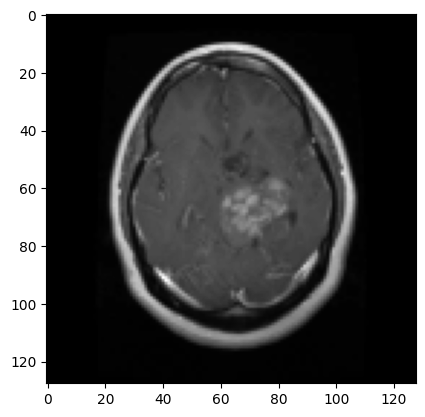

In [9]:
# Load dataset from data/chest_xray/train
dataroot = "../data/Brain Tumor Data Set/Brain Tumor Data Set"
dataset = datasets.ImageFolder(root=dataroot, transform=transform)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")
print(f"Dataset class to idx mapping: {dataset.class_to_idx}")

print(f"Dataset sample: {dataset.samples[0]}")

plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray')
plt.show()

tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0])


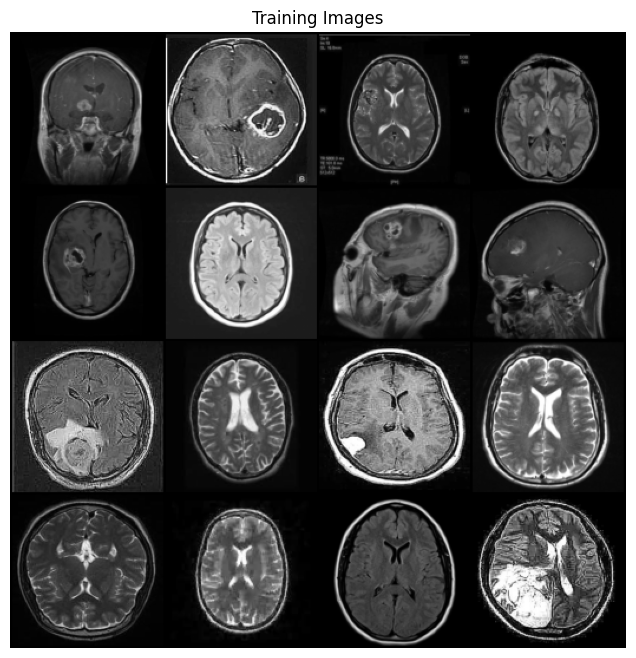

In [10]:
loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

# Print sample batch
real_batch = next(iter(loader))
print(real_batch[1][:16])
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:16], 4, padding=2, normalize=True).cpu(),
        (1, 2, 0),
    ),
    cmap='gray'
)
plt.show()

## Initializing Models & Optimizers

In [11]:
generator: Generator = Generator(
    Z_DIM, IMAGE_SHAPE, NUM_CLASSES, GEN_EMBEDDING, FEATURES_GEN, NGPU
).to(device)

if device == "cuda" and NGPU > 1:
    generator = nn.DataParallel(generator)

init_weights(generator)
print(generator)

Generator(
  (label_embedding): Embedding(2, 128)
  (main): Sequential(
    (0): ConvTranspose2d(228, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU()
    (14)

In [12]:
critic: Critic = Critic(IMAGE_SHAPE, NUM_CLASSES, FEATURES_CRITIC, NGPU).to(device)

if device == "cuda" and NGPU > 1:
    critic = nn.DataParallel(critic)

init_weights(critic)
print(critic)

Critic(
  (main): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): InstanceNorm2d(512, eps=1e

In [13]:
# Optimizer for generator
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_gen)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [14]:
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_critic)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [15]:
generator.train()

Generator(
  (label_embedding): Embedding(2, 128)
  (main): Sequential(
    (0): ConvTranspose2d(228, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU()
    (14)

In [16]:
critic.train()

Critic(
  (main): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): InstanceNorm2d(512, eps=1e

In [17]:
# Tensorboard
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

torch.Size([1, 100, 1, 1]) torch.Size([1])


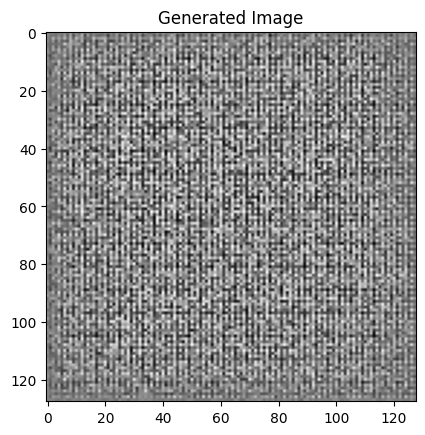

In [18]:
fixed_noise = torch.randn(1, Z_DIM, 1, 1).to(device)
fixed_labels = torch.randint(0, NUM_CLASSES, (1,)).to(device)

print(fixed_noise.shape, fixed_labels.shape)

plt.imshow(
    np.transpose(
        vutils.make_grid(
            generator(fixed_noise, fixed_labels).detach().cpu()[:1], padding=2, normalize=True
        ),
        (1, 2, 0),
    ),
    cmap='gray'
)
plt.title("Generated Image")
plt.show()

## Training

In [19]:
step = 0
generator_losses = []
critic_losses = []

In [20]:
# Training starts time
start_time = time.time()
print(f"Training started at {time.strftime('%X')}")

Training started at 15:59:16


In [21]:
# os.mkdir("/kaggle/working/model_states")

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [0/100] Batch 0/36                       Loss D: -6.9373, loss G: 6.7969


100%|██████████| 36/36 [02:16<00:00,  3.79s/it]


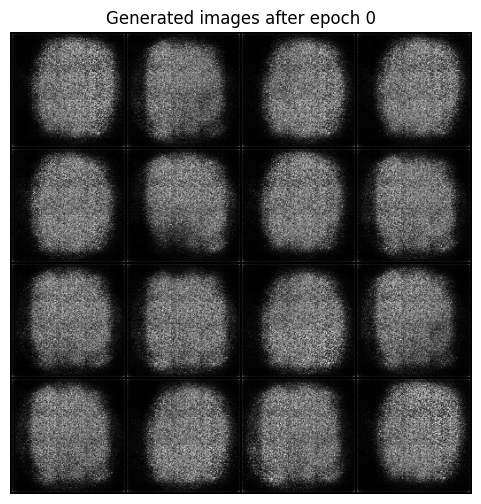

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [1/100] Batch 0/36                       Loss D: -19.6616, loss G: 20.9855


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [2/100] Batch 0/36                       Loss D: -21.4902, loss G: 18.6564


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [3/100] Batch 0/36                       Loss D: -18.6385, loss G: 19.6441


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [4/100] Batch 0/36                       Loss D: -17.8913, loss G: 18.6228


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [5/100] Batch 0/36                       Loss D: -13.3308, loss G: 14.0765


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [6/100] Batch 0/36                       Loss D: -13.2940, loss G: 13.3232


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [7/100] Batch 0/36                       Loss D: -13.0372, loss G: 17.7123


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [8/100] Batch 0/36                       Loss D: -12.1830, loss G: 11.4447


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [9/100] Batch 0/36                       Loss D: -12.9031, loss G: 10.2583


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [10/100] Batch 0/36                       Loss D: -11.1545, loss G: 15.6280


100%|██████████| 36/36 [04:33<00:00,  7.59s/it]


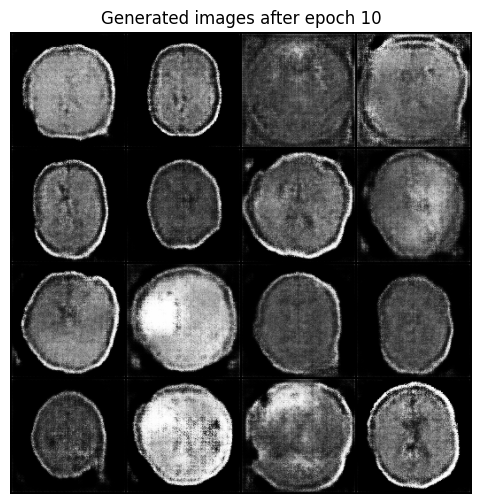

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [11/100] Batch 0/36                       Loss D: -14.0174, loss G: 16.2918


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [12/100] Batch 0/36                       Loss D: -12.3630, loss G: 13.4112


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [13/100] Batch 0/36                       Loss D: -12.3992, loss G: 13.3805


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [14/100] Batch 0/36                       Loss D: -14.0474, loss G: 15.5721


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [15/100] Batch 0/36                       Loss D: -13.7979, loss G: 14.7408


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [16/100] Batch 0/36                       Loss D: -14.5423, loss G: 15.4588


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [17/100] Batch 0/36                       Loss D: -13.0904, loss G: 10.2173


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [18/100] Batch 0/36                       Loss D: -14.9642, loss G: 12.3118


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [19/100] Batch 0/36                       Loss D: -13.8454, loss G: 8.9536


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [20/100] Batch 0/36                       Loss D: -14.1014, loss G: 16.9331


100%|██████████| 36/36 [04:36<00:00,  7.68s/it]


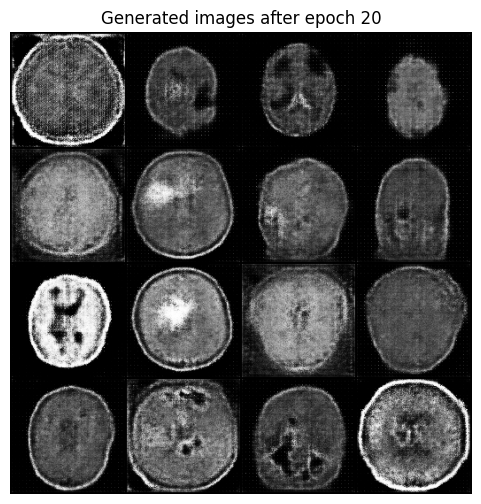

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [21/100] Batch 0/36                       Loss D: -15.5877, loss G: 14.5436


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [22/100] Batch 0/36                       Loss D: -15.4777, loss G: 13.3347


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [23/100] Batch 0/36                       Loss D: -13.7325, loss G: 16.5789


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [24/100] Batch 0/36                       Loss D: -13.6309, loss G: 11.0581


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [25/100] Batch 0/36                       Loss D: -17.0165, loss G: 10.9610


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [26/100] Batch 0/36                       Loss D: -16.8631, loss G: 21.2550


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [27/100] Batch 0/36                       Loss D: -16.2427, loss G: 13.7357


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [28/100] Batch 0/36                       Loss D: -14.8615, loss G: 12.5608


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [29/100] Batch 0/36                       Loss D: -17.2635, loss G: 21.3979


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [30/100] Batch 0/36                       Loss D: -15.5244, loss G: 16.7584


100%|██████████| 36/36 [04:34<00:00,  7.63s/it]


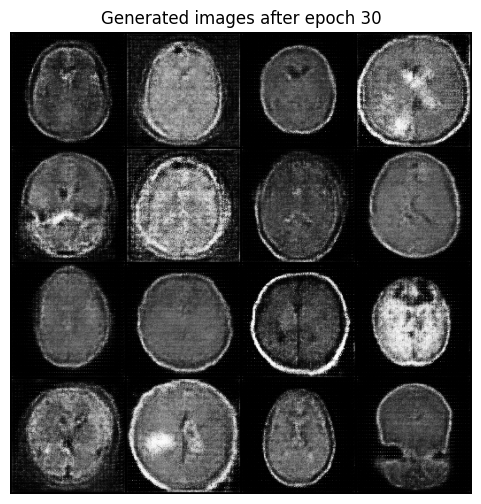

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [31/100] Batch 0/36                       Loss D: -16.3222, loss G: 16.0779


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [32/100] Batch 0/36                       Loss D: -16.1415, loss G: 14.1103


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [33/100] Batch 0/36                       Loss D: -15.8626, loss G: 13.5631


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [34/100] Batch 0/36                       Loss D: -16.2190, loss G: 16.5982


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [35/100] Batch 0/36                       Loss D: -18.7717, loss G: 13.8227


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [36/100] Batch 0/36                       Loss D: -17.4014, loss G: 15.6168


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [37/100] Batch 0/36                       Loss D: -15.8454, loss G: 16.6611


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [38/100] Batch 0/36                       Loss D: -17.3870, loss G: 17.3794


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [39/100] Batch 0/36                       Loss D: -19.4781, loss G: 15.5892


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [40/100] Batch 0/36                       Loss D: -16.6011, loss G: 15.9627


100%|██████████| 36/36 [04:35<00:00,  7.67s/it]


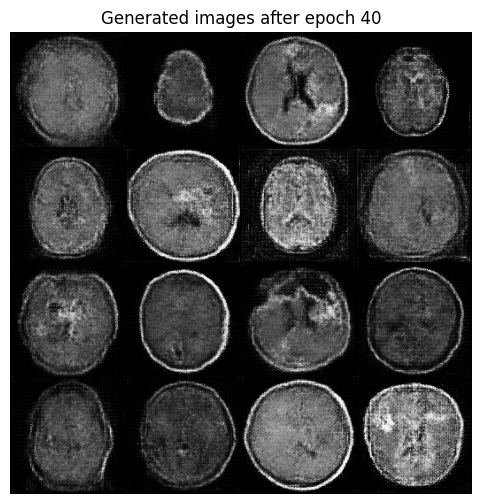

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [41/100] Batch 0/36                       Loss D: -16.5779, loss G: 16.1815


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [42/100] Batch 0/36                       Loss D: -17.6141, loss G: 17.1227


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [43/100] Batch 0/36                       Loss D: -17.7271, loss G: 15.4424


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [44/100] Batch 0/36                       Loss D: -18.4946, loss G: 19.6825


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [45/100] Batch 0/36                       Loss D: -16.4680, loss G: 22.1215


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [46/100] Batch 0/36                       Loss D: -17.3697, loss G: 20.3924


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [47/100] Batch 0/36                       Loss D: -17.3221, loss G: 16.4217


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [48/100] Batch 0/36                       Loss D: -17.9447, loss G: 18.7665


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [49/100] Batch 0/36                       Loss D: -18.1358, loss G: 18.9968


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [50/100] Batch 0/36                       Loss D: -17.2971, loss G: 19.8412


100%|██████████| 36/36 [04:31<00:00,  7.55s/it]


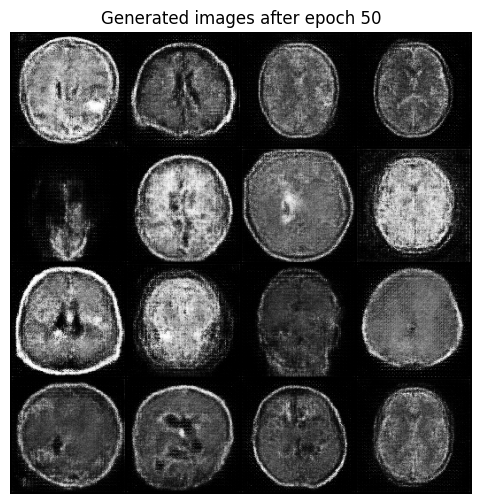

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [51/100] Batch 0/36                       Loss D: -16.3887, loss G: 20.0740


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [52/100] Batch 0/36                       Loss D: -18.1585, loss G: 22.0050


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [53/100] Batch 0/36                       Loss D: -17.9218, loss G: 25.5331


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [54/100] Batch 0/36                       Loss D: -17.6096, loss G: 20.3962


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [55/100] Batch 0/36                       Loss D: -17.7845, loss G: 19.0457


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [56/100] Batch 0/36                       Loss D: -18.4729, loss G: 20.3478


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [57/100] Batch 0/36                       Loss D: -18.5333, loss G: 21.5385


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [58/100] Batch 0/36                       Loss D: -16.9760, loss G: 19.6828


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [59/100] Batch 0/36                       Loss D: -17.8316, loss G: 23.0091


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [60/100] Batch 0/36                       Loss D: -17.5504, loss G: 21.8395


100%|██████████| 36/36 [04:31<00:00,  7.53s/it]


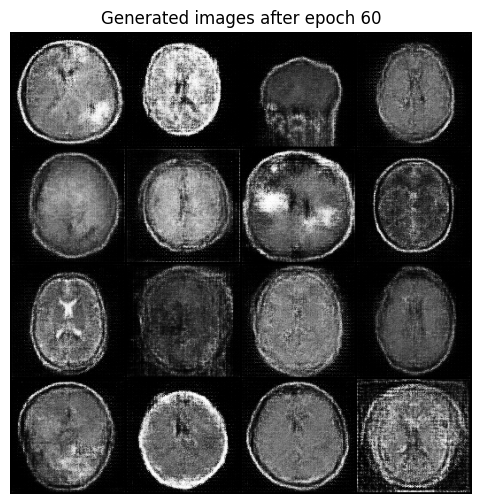

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [61/100] Batch 0/36                       Loss D: -17.8729, loss G: 22.8481


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [62/100] Batch 0/36                       Loss D: -19.3270, loss G: 24.7046


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [63/100] Batch 0/36                       Loss D: -17.5965, loss G: 22.3153


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [64/100] Batch 0/36                       Loss D: -18.5387, loss G: 23.4702


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [65/100] Batch 0/36                       Loss D: -19.4246, loss G: 23.7978


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [66/100] Batch 0/36                       Loss D: -19.1053, loss G: 28.2013


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [67/100] Batch 0/36                       Loss D: -19.3642, loss G: 21.9716


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [68/100] Batch 0/36                       Loss D: -20.1659, loss G: 28.8016


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [69/100] Batch 0/36                       Loss D: -18.1414, loss G: 24.5207


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [70/100] Batch 0/36                       Loss D: -18.0986, loss G: 23.0752


100%|██████████| 36/36 [04:31<00:00,  7.54s/it]


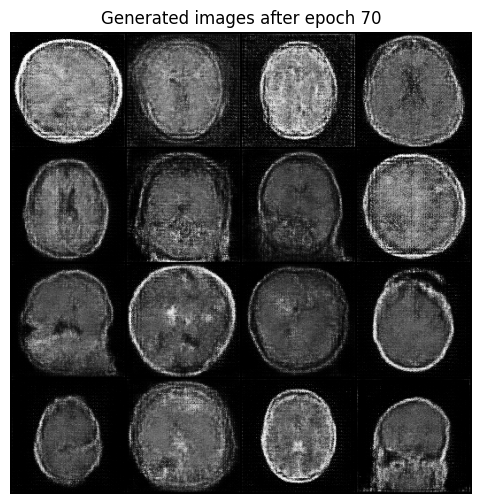

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [71/100] Batch 0/36                       Loss D: -21.2317, loss G: 22.4592


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [72/100] Batch 0/36                       Loss D: -18.1298, loss G: 26.6458


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [73/100] Batch 0/36                       Loss D: -17.4734, loss G: 24.5363


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [74/100] Batch 0/36                       Loss D: -18.3706, loss G: 28.9080


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [75/100] Batch 0/36                       Loss D: -18.6053, loss G: 25.4328


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [76/100] Batch 0/36                       Loss D: -20.5804, loss G: 23.7571


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [77/100] Batch 0/36                       Loss D: -18.0347, loss G: 27.4858


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [78/100] Batch 0/36                       Loss D: -19.6711, loss G: 26.3882


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [79/100] Batch 0/36                       Loss D: -16.9151, loss G: 25.9355


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [80/100] Batch 0/36                       Loss D: -20.4874, loss G: 25.6714


100%|██████████| 36/36 [04:31<00:00,  7.55s/it]


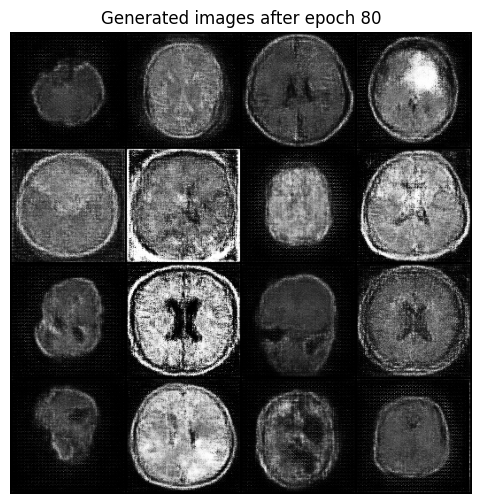

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [81/100] Batch 0/36                       Loss D: -18.3500, loss G: 24.0926


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [82/100] Batch 0/36                       Loss D: -19.1324, loss G: 28.3743


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [83/100] Batch 0/36                       Loss D: -17.0877, loss G: 28.7623


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [84/100] Batch 0/36                       Loss D: -18.7028, loss G: 28.5912


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [85/100] Batch 0/36                       Loss D: -20.0649, loss G: 28.1117


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [86/100] Batch 0/36                       Loss D: -17.5218, loss G: 27.4693


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [87/100] Batch 0/36                       Loss D: -17.9517, loss G: 24.7670


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [88/100] Batch 0/36                       Loss D: -18.4301, loss G: 34.1088


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [89/100] Batch 0/36                       Loss D: -18.0108, loss G: 29.2156


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [90/100] Batch 0/36                       Loss D: -19.0437, loss G: 31.1616


100%|██████████| 36/36 [04:28<00:00,  7.46s/it]


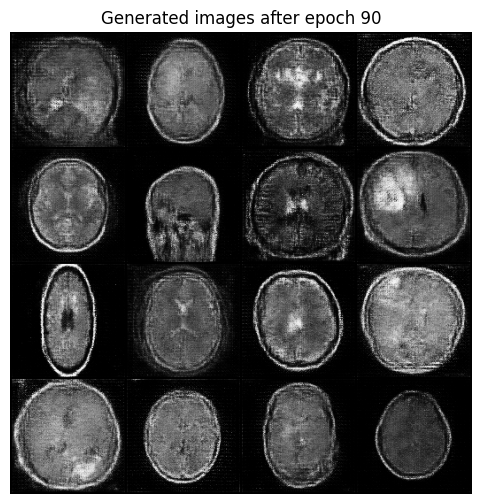

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [91/100] Batch 0/36                       Loss D: -19.3903, loss G: 25.2187


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [92/100] Batch 0/36                       Loss D: -19.8924, loss G: 24.9562


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [93/100] Batch 0/36                       Loss D: -18.4159, loss G: 28.7013


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [94/100] Batch 0/36                       Loss D: -19.4595, loss G: 29.0460


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [95/100] Batch 0/36                       Loss D: -18.5765, loss G: 26.5895


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [96/100] Batch 0/36                       Loss D: -18.9496, loss G: 29.5235


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [97/100] Batch 0/36                       Loss D: -17.0852, loss G: 28.7161


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [98/100] Batch 0/36                       Loss D: -18.8311, loss G: 30.4547


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [99/100] Batch 0/36                       Loss D: -20.3276, loss G: 30.8429


100%|██████████| 36/36 [04:28<00:00,  7.46s/it]


In [22]:
%matplotlib inline
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # => min -E[critic(real)] + E[critic(fake)]
        critic_loss = 0
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = generator(noise, labels)

            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)

            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            critic_loss += loss_critic.item() if batch_idx in (0, len(loader)) else 0
        

        # Train Generator: min -E[critic(gen_fake)] <-> max E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx in (0, len(loader)):
            critic_losses.append(critic_loss / CRITIC_ITERATIONS)
            generator_losses.append(loss_gen.item())

            # Print losses occasionally and print to tensorboard
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = vutils.make_grid(
                    real[:32], normalize=True, padding=2
                )
                img_grid_fake = vutils.make_grid(
                    fake[:32], normalize=True, padding=2
                )

                writer_real.add_image(
                    "Real images", img_grid_real, global_step=step
                )
                writer_fake.add_image("Fake images", img_grid_fake, global_step=step)

            step += 1
    
    # Print images after each epoch
    if epoch % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
            sample_labels = torch.randint(0, NUM_CLASSES, (16,)).to(device)
            sample = generator(sample_noise, sample_labels)
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.title(f"Generated images after epoch {epoch}")
            plt.imshow(
                np.transpose(
                    vutils.make_grid(sample[:16], 4, padding=2, normalize=True).cpu(),
                    (1, 2, 0),
                )
            )
            plt.show()
        
        # Save model after each epoch
        torch.save(generator.state_dict(), f"model_states/tumor_generator_epoch_{epoch}.pth")
        torch.save(critic.state_dict(), f"model_states/tumor_critic_epoch_{epoch}.pth")


# Save model after training
torch.save(generator.state_dict(), "tumor_generator.pt")
torch.save(critic.state_dict(), "tumor_critic.pt")

In [23]:
# Training ends time
end_time = time.time()
print(f"Training ended at {time.strftime('%X')}")

# Print total time taken
print(f"Total time taken: {time.strftime('%H:%M:%S', time.gmtime(end_time - start_time))}")

Training ended at 23:28:24
Total time taken: 07:29:07


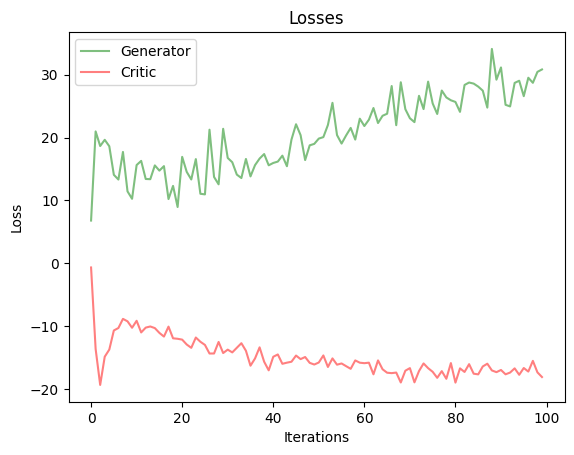

In [24]:
# Plot losses
plt.plot(generator_losses, label="Generator", alpha=0.5, color="green")
plt.plot(critic_losses, label="Critic", alpha=0.5, color="red")
plt.title("Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Final Outputs

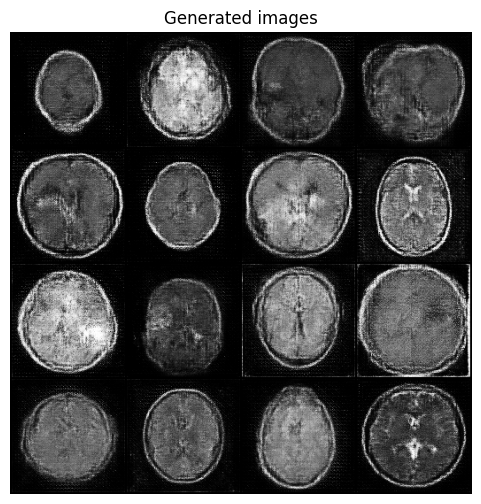

In [25]:
# Plot some images
with torch.no_grad():
    sample_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
    sample_labels = torch.randint(0, NUM_CLASSES, (16,)).to(device)
    sample = generator(sample_noise, sample_labels)
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title("Generated images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(sample[:16], 4, padding=2, normalize=True).cpu(),
            (1, 2, 0),
        ),
        cmap='gray'
    )
    plt.show()